# 研究肖申克的救赎用户评论

## 提出问题
- 研究用户评论的关键词云
- 提取用户名、点赞数、星级和评论

## 数据整理

In [3]:
import re
import requests
import json
import time
import jieba
import imageio
import pandas as pd
import numpy as np
import seaborn as sns
from pyquery import PyQuery
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from jieba.analyse import extract_tags, textrank

plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

### 数据获取
- User-Agent:告知服务器，客户机的软件环境

In [4]:
url = "https://movie.douban.com/subject/1292052/comments"
header = {
    "User-Agent": "Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.120 Safari/537.36"
}
# https://movie.douban.com/subject/1292052/comments?start=20&limit=20&sort=new_score&status=P
query_string = {
    "start": 0,
    "limit": 20,
    "sort": "new_score",
    "status": "P",
    "percent_type": ""
}

In [5]:
response = requests.get(url, headers = header, params = query_string)
response

<Response [200]>

In [5]:
response.url

'https://movie.douban.com/subject/1292052/comments?start=20&limit=20&sort=new_score&status=P&percent_type='

In [6]:
# PyQuery来提取网页内容结构
query = PyQuery(response.text)

In [7]:
# 获取总的评论数
text_comments = [item("span").text() for item in query("li.is-active").items()][0]
num_comments = re.compile(r"\d*").findall(text_comments)[3]
num_comments = int(num_comments)
num_comments

310289

In [8]:
step = 20
query_string["limit"] = step
max_comments = 200
user_id = []
votes = []
rating = []
comments = []
for startIndex in range(0, max_comments + 1- step, step):
    query_string["start"] = startIndex
    response = requests.get(url, headers = header, params = query_string)
    query = PyQuery(response.text)
    
    # 提取用户名
    user_id += [item("a").text() for item in query("span.comment-info").items()]
    
    # 提取点赞数
    votes += [item.text() for item in query("span.votes").items()]
    
    #  获取星级
    for item in query("span").items():
        if item.attr("class") and ("allstar" in item.attr("class")):
            rating.append(item.attr("class")[len("allstar")])
            
    # 获取评论
    comments += [item.text() for item in query("span.short").items()]
    time.sleep(2)

In [9]:
# 创建Pandas表单
columns = ["user_id", "votes", "rating", "comments"]
dataset = [user_id, votes, rating, comments]
df_shawshank = pd.DataFrame()
for column_name, data in zip(columns, dataset):
    df_shawshank[column_name] = pd.Series(data)
df_shawshank.head()

,user_id,votes,rating,comments
0,犀牛,13870,5,当年的奥斯卡颁奖礼上，被如日中天的《阿甘正传》掩盖了它的光彩，而随着时间的推移，这部电影在越...
1,kingfish,24812,5,不需要女主角的好电影
2,如小果,14837,5,恐惧让你沦为囚犯，希望让你重获自由。——《肖申克的救赎》
3,文泽尔,2039,4,人的生命不过是从一个洞穴通往另一个世界..然后在那个世界的雨中继续颤抖.i hope
4,Eve|Classified,6683,5,“这是一部男人必看的电影。”人人都这么说。但单纯从性别区分，就会让这电影变狭隘。《肖申克的救...


In [10]:
df_shawshank.shape

(200, 4)

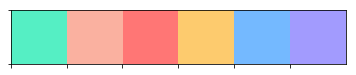

In [11]:
color_board =["#55efc4", "#fab1a0", "#ff7675",  "#fdcb6e", "#74b9ff", "#a29bfe" ]
sns.set_palette(color_board)
sns.palplot(color_board)

Text(0.5,1,'评论星级占比情况统计')

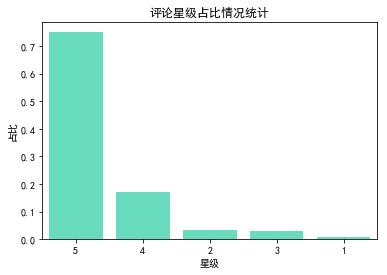

In [43]:
num_rating = df_shawshank.shape[0]
max_prop = df_shawshank["rating"].value_counts().max() / num_rating
tick_props = np.arange(0, max_prop, 0.1)
tick_names = ["{:0.1f}".format(item) for item in tick_props]

sns.countplot(data = df_shawshank, x = "rating", color = sns.color_palette()[0])
plt.yticks(tick_props * num_rating, tick_names)
plt.xlabel("星级")
plt.ylabel("占比")
plt.title("评论星级占比情况统计")

In [ ]:
# 将所有的评论进行组合
total_comments = ""
for index, row in df_shawshank.iterrows():
    total_comments+=row["comments"]

In [88]:
invalid_keywords = ["一部", "电影", "这部", "片子", "真的", "要么", \
                    "没有", "豆瓣",  "一个", "就是", "时候", "get", \
                   "没有", "影片" ,"还有", "感觉", "还有", "获得", "人们", \
                   "东西", "觉得", "无法", "知道"]

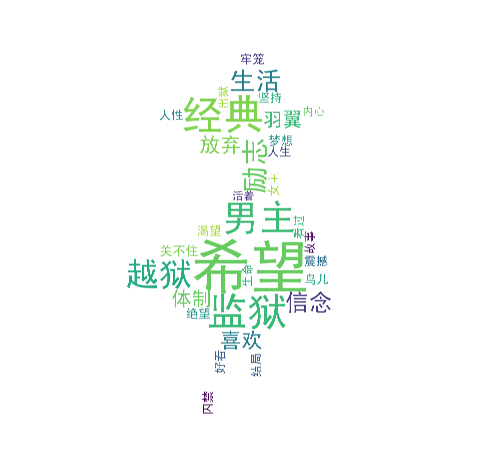

In [92]:
# TF-idf方式提取关键词,计算词频
keywords = {}
for keyword, weight in extract_tags(total_comments, withWeight=True, topK=40, allowPOS=('ns', 'n', 'vn', 'v')):
    if keyword not in invalid_keywords:
        keywords[keyword] = weight

wc = WordCloud(width=384, height=216, \
                mask = imageio.imread("./img/alice_mask.png"), \
                background_color = "white",\
                font_path=r"../font/SimHei.ttf",
                stopwords = stopwords, \
                scale=20) \
                .generate_from_frequencies(keywords)
plt.figure(figsize=(10,8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

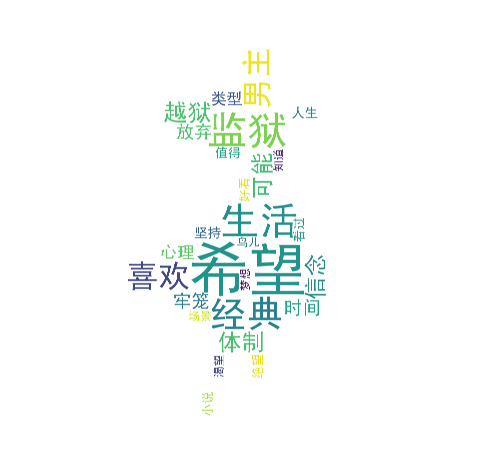

In [89]:
# TextRank算法统计词频
keywords = {}
for keyword, weight in textrank(total_comments, withWeight=True, topK=40):
    if keyword not in invalid_keywords:
        keywords[keyword] = weight
# 词云
wc = WordCloud(width=384, height=216, \
                mask = imageio.imread("./img/alice_mask.png"), \
                background_color = "white",\
                font_path=r"../font/SimHei.ttf",
                stopwords = stopwords, \
                scale=20) \
                .generate_from_frequencies(keywords)
plt.figure(figsize=(10,8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()